In [1]:
!pip install pandas
!pip install transformers
!pip3 install torch==1.8.2+cu111 torchvision==0.9.2+cu111 torchaudio==0.8.2 -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html
!pip install scikit-learn    
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in links: https://download.pytorch.org/whl/lts/1.8/torch_lts.html
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import pandas as pd
import numpy as np
import torch
import time
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer, WordNetLemmatizer 
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/ocw/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
fake_raw_data = pd.read_csv('Fake_raw_data.csv')
real_raw_data = pd.read_csv('Real_raw_data.csv')

In [4]:
fake_raw_data

,data
0,Spraying chlorine or alcohol on the skin kills...
1,Only older adults and young people are at risk
2,Children cannot get COVID-19
3,COVID-19 is just like the flu
4,Everyone with COVID-19 dies
...,...
861,Trey Gowdy said coronavirus shutdowns were sus...
862,All elective or non-emergency surgeries are ba...
863,U.S. House Speaker Nancy Pelosi was in Wuhan C...
864,U.S. House Speaker Nancy Pelosi was in Wuhan C...


In [5]:
real_raw_data

,data
0,Should children wear a mask?
1,Are there situations where children aged 5 yea...
2,Should children with developmental disabilitie...
3,Should children who have health issues or a me...
4,What type of mask should children wear?
...,...
4059,Says researchers found a “fabric that kills co...
4060,“With retail people are moving around and you ...
4061,Says President Donald Trump “took more than a ...
4062,As of June 23 the COVID-19 death rate is “way ...


In [6]:
print(fake_raw_data.isnull().any())
print()
print(real_raw_data.isnull().any())

data    False
dtype: bool

data    False
dtype: bool


In [7]:
# Cleaning comment
def clean_comment(comment):
    p = """'!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~'"""
    stop_words = stopwords.words('english')
    stop_words.remove('not')
    comment = [word.lower() for word in comment]
    comment = [''.join(w for w in word if w not in p) for word in comment]
    comment = [word for word in comment if word not in stop_words]
    return comment

# Stemming and Lemmantization
def stemming(comment):
    return [SnowballStemmer(language="english").stem(word) for word in comment]

def lemmatization(comment):
    return [WordNetLemmatizer.lemmatize(word) for word in comment]

def prep_comment(comment):
    regexp = "([a-zA-Z]+(?:’[a-z]+)?)"
    regex_tokenizer = RegexpTokenizer(regexp)
    comment = regex_tokenizer.tokenize(comment)
    comment = clean_comment(comment)
    # comment = stemming(comment) 
    return ' '.join(comment)

In [8]:
X_fake = [prep_comment(comment) for comment in fake_raw_data['data'].values]

In [9]:
X_fake

['spraying chlorine alcohol skin kills viruses body',
 'older adults young people risk',
 'children cannot get covid',
 'covid like flu',
 'everyone covid dies',
 'cats dogs spread coronavirus',
 'face masks always protect coronavirus',
 'hand dryers kill coronavirus',
 'sars cov mutated form common cold',
 'someone minutes catch virus',
 'rinsing nose saline protects coronavirus',
 'protect gargling bleach',
 'antibiotics kill coronavirus',
 'thermal scanners diagnose coronavirus',
 'garlic protects coronaviruses',
 'parcels china spread coronavirus',
 'home remedies cure protect covid',
 'catch coronavirus eating chinese food us',
 'catch coronavirus urine feces',
 'virus die temperatures rise spring',
 'coronavirus deadliest virus known humans',
 'flu pneumonia vaccines protect covid',
 'virus originated laboratory china',
 'outbreak began people ate bat soup',
 'g helps sars cov spread',
 'drinking alcohol reduces risk infection',
 'injecting consuming bleach disinfectant kills vir

In [10]:
y_fake = [0 for _ in range(len(X_fake))]
len(y_fake)

866

In [11]:
X_real = [prep_comment(comment) for comment in real_raw_data['data'].values]

In [12]:
X_real

['children wear mask',
 'situations children aged years may wear required wear mask',
 'children developmental disabilities wear masks',
 'children health issues medical condition compromises immune system wear mask',
 'type mask children wear',
 'children wear mask',
 'child wear mask home',
 'teachers adults working children wear mask',
 'children wear mask playing sports physical activities',
 'alternatives fabric masks face shields',
 'contact tracing',
 'contact tracing work',
 'defined contact',
 'contact tracing help controlling spread virus',
 'contact tracing implemented',
 'happens contact',
 'needed successful contact tracing',
 'tools used contact tracing',
 'considered data protection',
 'get covid eating fresh foods like fruits vegetables',
 'wash fruits vegetables time covid',
 'virus causes covid live surface food packaging',
 'virus causes covid transmitted consumption cooked foods including animal products',
 'safe go grocery stores food markets',
 'safe groceries del

In [13]:
y_real = [1 for _ in range(len(X_real))]
len(y_real)

4064

In [14]:
X_all = X_real + X_fake
y_all = y_real + y_fake
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, random_state=0, test_size=0.2)

In [15]:
max_seq_len_real = max([len(x.split(' ')) for x in X_real])
max_seq_len_fake = max([len(x.split(' ')) for x in X_fake])
max_seq_len = max(max_seq_len_real, max_seq_len_fake)
max_seq_len

35

In [16]:
df = pd.DataFrame(pd.concat([pd.DataFrame(X_all,columns=['text']), pd.DataFrame(y_all, columns=['label'])], axis=1))
df

,text,label
0,children wear mask,1
1,situations children aged years may wear requir...,1
2,children developmental disabilities wear masks,1
3,children health issues medical condition compr...,1
4,type mask children wear,1
...,...,...
4925,trey gowdy said coronavirus shutdowns suspicio...,0
4926,elective non emergency surgeries banned priori...,0
4927,u house speaker nancy pelosi wuhan china time ...,0
4928,u house speaker nancy pelosi wuhan china six d...,0


In [17]:
train_text, val_text, train_labels, val_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2021, 
                                                                    test_size=0.2, 
                                                                    stratify=df['label'])

In [18]:
# paramters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
data = tokenizer.batch_encode_plus(["Children cannot get COVID-19"], padding=True, return_token_type_ids=False)

print(data['input_ids'],'\n')
print(data['attention_mask'])

[[101, 2336, 3685, 2131, 2522, 17258, 1011, 2539, 102]] 

[[1, 1, 1, 1, 1, 1, 1, 1, 1]]


In [21]:
max_seq_len = 25

In [22]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
# tokens_test = tokenizer.batch_encode_plus(
#     test_text.tolist(),
#     max_length = max_seq_len,
#     pad_to_max_length=True,
#     truncation=True,
#     return_token_type_ids=False
# )

/home/ocw/anaconda3/envs/MLDA/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [23]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

In [24]:
#define a batch size
batch_size = 8

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [25]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [26]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.4)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [48]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

from torch.optim import lr_scheduler

# push the model to GPU
model = model.to(device)

# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 0.001)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [49]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[2.84559885 0.60658259]


In [50]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 80

In [51]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
        
        for param_group in optimizer.param_groups:
            print("Current learning rate is: {}".format(param_group['lr']))
        print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)
    
    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    
    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)
  scheduler.step()
  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [52]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [53]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), f'BERT_{best_valid_loss:.3f}.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 80
Current learning rate is: 0.001
  Batch    50  of    493.
Current learning rate is: 0.001
  Batch   100  of    493.
Current learning rate is: 0.001
  Batch   150  of    493.
Current learning rate is: 0.001
  Batch   200  of    493.
Current learning rate is: 0.001
  Batch   250  of    493.
Current learning rate is: 0.001
  Batch   300  of    493.
Current learning rate is: 0.001
  Batch   350  of    493.
Current learning rate is: 0.001
  Batch   400  of    493.
Current learning rate is: 0.001
  Batch   450  of    493.

Evaluating...
  Batch    50  of    124.
  Batch   100  of    124.

Training Loss: 0.703
Validation Loss: 0.558

 Epoch 2 / 80
Current learning rate is: 0.0009000000000000001
  Batch    50  of    493.
Current learning rate is: 0.0009000000000000001
  Batch   100  of    493.
Current learning rate is: 0.0009000000000000001
  Batch   150  of    493.
Current learning rate is: 0.0009000000000000001
  Batch   200  of    493.
Current learning rate is: 0.000900000000

Current learning rate is: 0.00031381059609000004
  Batch   200  of    493.
Current learning rate is: 0.00031381059609000004
  Batch   250  of    493.
Current learning rate is: 0.00031381059609000004
  Batch   300  of    493.
Current learning rate is: 0.00031381059609000004
  Batch   350  of    493.
Current learning rate is: 0.00031381059609000004
  Batch   400  of    493.
Current learning rate is: 0.00031381059609000004
  Batch   450  of    493.

Evaluating...
  Batch    50  of    124.
  Batch   100  of    124.

Training Loss: 0.493
Validation Loss: 0.439

 Epoch 13 / 80
Current learning rate is: 0.00028242953648100003
  Batch    50  of    493.
Current learning rate is: 0.00028242953648100003
  Batch   100  of    493.
Current learning rate is: 0.00028242953648100003
  Batch   150  of    493.
Current learning rate is: 0.00028242953648100003
  Batch   200  of    493.
Current learning rate is: 0.00028242953648100003
  Batch   250  of    493.
Current learning rate is: 0.0002824295364810000

Current learning rate is: 0.00010941898913151243
  Batch   350  of    493.
Current learning rate is: 0.00010941898913151243
  Batch   400  of    493.
Current learning rate is: 0.00010941898913151243
  Batch   450  of    493.

Evaluating...
  Batch    50  of    124.
  Batch   100  of    124.

Training Loss: 0.453
Validation Loss: 0.411

 Epoch 23 / 80
Current learning rate is: 9.847709021836118e-05
  Batch    50  of    493.
Current learning rate is: 9.847709021836118e-05
  Batch   100  of    493.
Current learning rate is: 9.847709021836118e-05
  Batch   150  of    493.
Current learning rate is: 9.847709021836118e-05
  Batch   200  of    493.
Current learning rate is: 9.847709021836118e-05
  Batch   250  of    493.
Current learning rate is: 9.847709021836118e-05
  Batch   300  of    493.
Current learning rate is: 9.847709021836118e-05
  Batch   350  of    493.
Current learning rate is: 9.847709021836118e-05
  Batch   400  of    493.
Current learning rate is: 9.847709021836118e-05
  Batch

  Batch   100  of    124.

Training Loss: 0.436
Validation Loss: 0.411

 Epoch 33 / 80
Current learning rate is: 3.433683820292515e-05
  Batch    50  of    493.
Current learning rate is: 3.433683820292515e-05
  Batch   100  of    493.
Current learning rate is: 3.433683820292515e-05
  Batch   150  of    493.
Current learning rate is: 3.433683820292515e-05
  Batch   200  of    493.
Current learning rate is: 3.433683820292515e-05
  Batch   250  of    493.
Current learning rate is: 3.433683820292515e-05
  Batch   300  of    493.
Current learning rate is: 3.433683820292515e-05
  Batch   350  of    493.
Current learning rate is: 3.433683820292515e-05
  Batch   400  of    493.
Current learning rate is: 3.433683820292515e-05
  Batch   450  of    493.

Evaluating...
  Batch    50  of    124.
  Batch   100  of    124.

Training Loss: 0.454
Validation Loss: 0.412

 Epoch 34 / 80
Current learning rate is: 3.090315438263264e-05
  Batch    50  of    493.
Current learning rate is: 3.090315438263264e-

Current learning rate is: 1.1972515182562031e-05
  Batch   150  of    493.
Current learning rate is: 1.1972515182562031e-05
  Batch   200  of    493.
Current learning rate is: 1.1972515182562031e-05
  Batch   250  of    493.
Current learning rate is: 1.1972515182562031e-05
  Batch   300  of    493.
Current learning rate is: 1.1972515182562031e-05
  Batch   350  of    493.
Current learning rate is: 1.1972515182562031e-05
  Batch   400  of    493.
Current learning rate is: 1.1972515182562031e-05
  Batch   450  of    493.

Evaluating...
  Batch    50  of    124.
  Batch   100  of    124.

Training Loss: 0.449
Validation Loss: 0.417

 Epoch 44 / 80
Current learning rate is: 1.0775263664305828e-05
  Batch    50  of    493.
Current learning rate is: 1.0775263664305828e-05
  Batch   100  of    493.
Current learning rate is: 1.0775263664305828e-05
  Batch   150  of    493.
Current learning rate is: 1.0775263664305828e-05
  Batch   200  of    493.
Current learning rate is: 1.0775263664305828e-0

Current learning rate is: 4.174557917929298e-06
  Batch   350  of    493.
Current learning rate is: 4.174557917929298e-06
  Batch   400  of    493.
Current learning rate is: 4.174557917929298e-06
  Batch   450  of    493.

Evaluating...
  Batch    50  of    124.
  Batch   100  of    124.

Training Loss: 0.465
Validation Loss: 0.417

 Epoch 54 / 80
Current learning rate is: 3.7571021261363684e-06
  Batch    50  of    493.
Current learning rate is: 3.7571021261363684e-06
  Batch   100  of    493.
Current learning rate is: 3.7571021261363684e-06
  Batch   150  of    493.
Current learning rate is: 3.7571021261363684e-06
  Batch   200  of    493.
Current learning rate is: 3.7571021261363684e-06
  Batch   250  of    493.
Current learning rate is: 3.7571021261363684e-06
  Batch   300  of    493.
Current learning rate is: 3.7571021261363684e-06
  Batch   350  of    493.
Current learning rate is: 3.7571021261363684e-06
  Batch   400  of    493.
Current learning rate is: 3.7571021261363684e-06
 


Evaluating...
  Batch    50  of    124.
  Batch   100  of    124.

Training Loss: 0.466
Validation Loss: 0.414

 Epoch 64 / 80
Current learning rate is: 1.3100205086376225e-06
  Batch    50  of    493.
Current learning rate is: 1.3100205086376225e-06
  Batch   100  of    493.
Current learning rate is: 1.3100205086376225e-06
  Batch   150  of    493.
Current learning rate is: 1.3100205086376225e-06
  Batch   200  of    493.
Current learning rate is: 1.3100205086376225e-06
  Batch   250  of    493.
Current learning rate is: 1.3100205086376225e-06
  Batch   300  of    493.
Current learning rate is: 1.3100205086376225e-06
  Batch   350  of    493.
Current learning rate is: 1.3100205086376225e-06
  Batch   400  of    493.
Current learning rate is: 1.3100205086376225e-06
  Batch   450  of    493.

Evaluating...
  Batch    50  of    124.
  Batch   100  of    124.

Training Loss: 0.457
Validation Loss: 0.412

 Epoch 65 / 80
Current learning rate is: 1.1790184577738603e-06
  Batch    50  of   

Current learning rate is: 4.567759074507748e-07
  Batch   150  of    493.
Current learning rate is: 4.567759074507748e-07
  Batch   200  of    493.
Current learning rate is: 4.567759074507748e-07
  Batch   250  of    493.
Current learning rate is: 4.567759074507748e-07
  Batch   300  of    493.
Current learning rate is: 4.567759074507748e-07
  Batch   350  of    493.
Current learning rate is: 4.567759074507748e-07
  Batch   400  of    493.
Current learning rate is: 4.567759074507748e-07
  Batch   450  of    493.

Evaluating...
  Batch    50  of    124.
  Batch   100  of    124.

Training Loss: 0.441
Validation Loss: 0.413

 Epoch 75 / 80
Current learning rate is: 4.1109831670569735e-07
  Batch    50  of    493.
Current learning rate is: 4.1109831670569735e-07
  Batch   100  of    493.
Current learning rate is: 4.1109831670569735e-07
  Batch   150  of    493.
Current learning rate is: 4.1109831670569735e-07
  Batch   200  of    493.
Current learning rate is: 4.1109831670569735e-07
  Bat

KeyboardInterrupt: 

In [33]:
import matplotlib.pyplot as plt

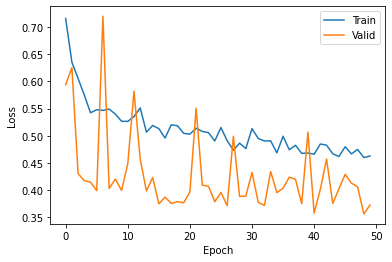

In [34]:
plt.plot(range(len(train_losses)), train_losses, label='Train')
plt.plot(range(len(valid_losses)), valid_losses, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [75]:
# pass the pre-trained BERT to our define architecture
test_model = BERT_Arch(bert)
test_model = test_model.to(device)
test_model.load_state_dict(torch.load('BERT1.pt'))

<All keys matched successfully>

In [76]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

max_seq_len = 25

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])

with torch.no_grad():
  pred_prob = test_model(test_seq.to(device), test_mask.to(device))
  pred_prob = pred_prob.detach().cpu().numpy()

preds = np.argmax(pred_prob, axis = 1)

#print([preds.tolist(), pred_prob.tolist()])
sum(1 for x,y in zip(val_labels.tolist(),preds.tolist()) if x == y) / len(val_text.tolist())

0.8529411764705882